Code for project 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Plot of the variables: High, Low, Close

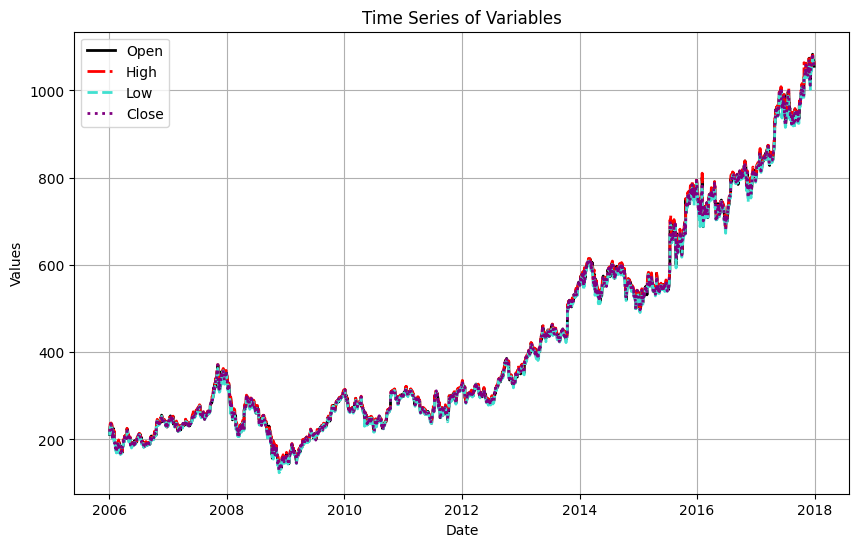

In [2]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)
Open=data['Open']
High=data['High']
Low=data['Low']
Close=data['Close']
Volume=data['Volume']
plt.figure(figsize=(10, 6))
plt.plot(data.index, Open, label='Open', linewidth=2, linestyle='-', color='black' )
plt.plot(data.index, High, label='High', linewidth=2, linestyle='-.', color='red' )
plt.plot(data.index, Low, label='Low', linewidth=2, linestyle='--', color='turquoise' )
plt.plot(data.index, Close, label='Close', linewidth=2,linestyle=':', color='purple' )
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)
plt.show()




Plot mean and SD envelopes to see better

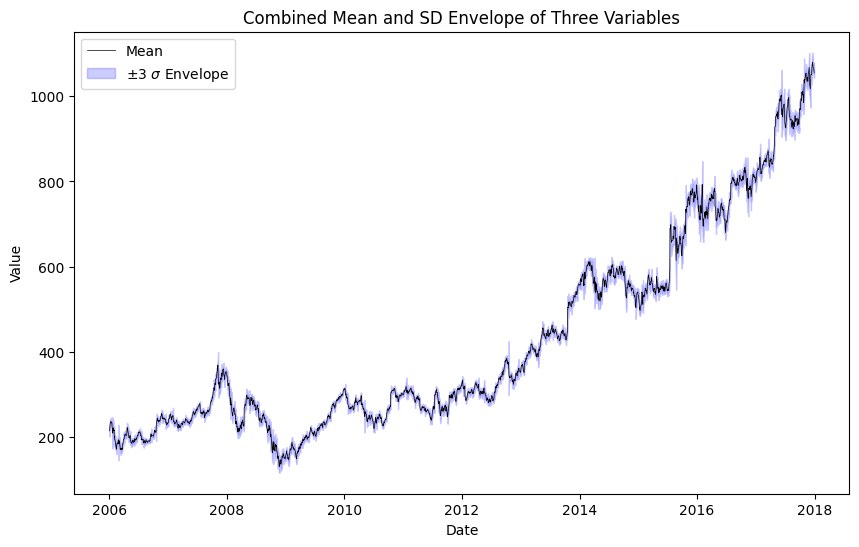

In [3]:
mean_all = data.iloc[:, [0,1, 2, 3]].mean(axis=1)
std_dev_all = data.iloc[:, [0,1, 2, 3]].std(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(data.index, mean_all, label='Mean', color='black', linewidth=0.5)
plt.fill_between(
    data.index,
    mean_all - 3*std_dev_all,  
    mean_all + 3*std_dev_all,  
    color='blue',
    alpha=0.2,  # Adjust transparency
    label='±3 $\sigma$ Envelope'
)

# Labeling the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Combined Mean and SD Envelope of Three Variables')
plt.legend()
plt.show()


Plot of the variable Volume

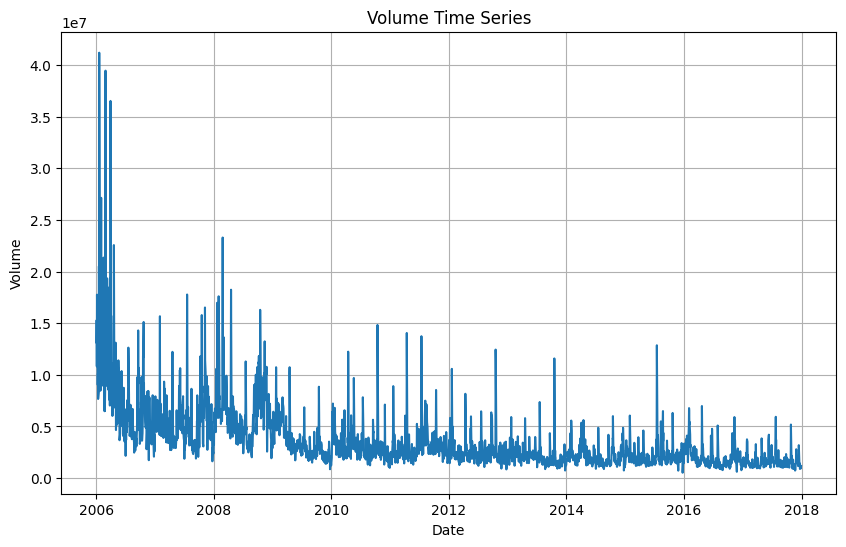

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, Volume, label="Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Time Series')
plt.grid(True)
plt.savefig("Volume Time Series.png")
plt.show()

Seasonal Trent decomposition using LOESS (STL)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")


Seasonal Trend Decomposition


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

cases=["Open","High","Low","Close", "Volume"]
results={}
for cs in cases:
    data[cs] = data[cs].fillna(method='ffill')
    data[cs].index = pd.to_datetime(data.index)
    data[cs] = data[cs].asfreq('B')

    # daily seasonality
    result = seasonal_decompose(data[cs], model='multiplicative', period=365)
    results[cs]=result
    result.plot()
    plt.show()
    plt.savefig("TSDec_"+cs+".png")


/tmp/ipykernel_43683/1046671661.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[cs] = data[cs].fillna(method='ffill')


KeyboardInterrupt: 

Volume traded per price graph

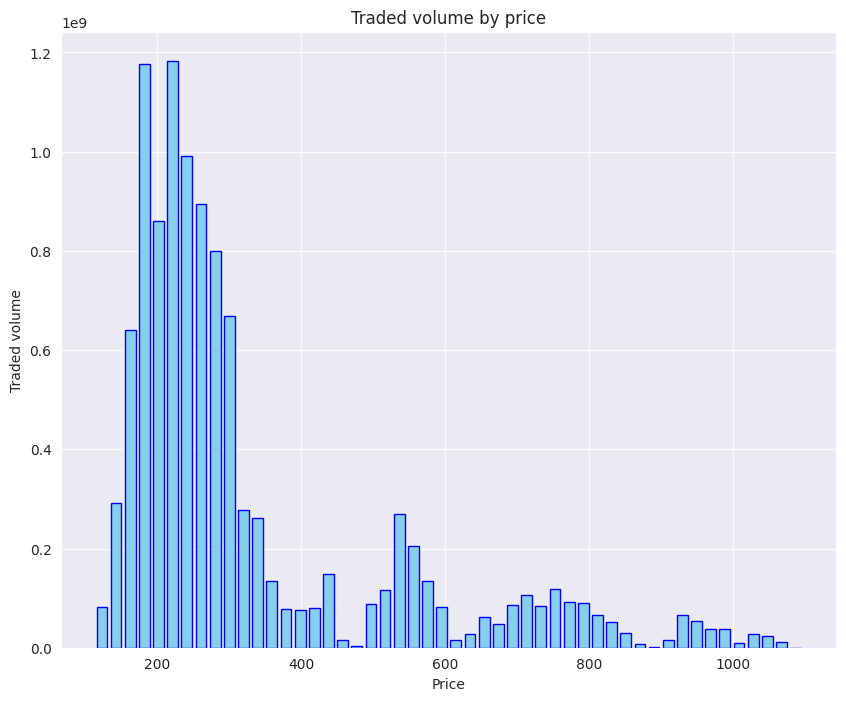

In [ ]:
import numpy as np

num_bins = 50 # Number of bins

# Define price bins based on high and low price
price_min = data['Low'].min()
price_max = data['High'].max()
bins = np.linspace(price_min, price_max, num_bins)

# Calculate the midpoints of the bins for plotting

# Calculate the volume in each price bin
volume_by_price = np.zeros(len(bins))

for i in range(len(bins)-1):
    mask = (Close >= bins[i]) & (Close < bins[i + 1])
    volume_by_price[i] = Volume[mask].sum()

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Create a horizontal bar chart for volume by price
ax.bar(bins, volume_by_price, align='center', color='skyblue', edgecolor='blue', width=15)
ax.set_xlabel('Price')
ax.set_ylabel('Traded volume')
ax.set_title('Traded volume by price')
plt.savefig("Traded volume by price.png")
plt.show()

Autocorrelation analysis

            0        1        2        3           4
0      211.47   218.05   209.32   217.83  13137450.0
1      222.17   224.70   220.09   222.84  15292353.0
2      223.22   226.00   220.97   225.85  10815661.0
3      228.66   235.49   226.85   233.06  17759521.0
4      233.44   236.94   230.70   233.68  12795837.0
...       ...      ...      ...      ...         ...
3014  1070.00  1071.72  1067.64  1068.86    889446.0
3015  1068.64  1068.86  1058.64  1065.85    918767.0
3016  1066.60  1068.27  1058.38  1060.20   1116203.0
3017  1062.25  1064.84  1053.38  1055.95    994249.0
3018  1055.49  1058.05  1052.70  1053.40   1180340.0

[3019 rows x 5 columns]
          0         1         2         3         4
0  1.000000  0.999894  0.999841  0.999742 -0.443155
1  0.999894  1.000000  0.999827  0.999866 -0.440717
2  0.999841  0.999827  1.000000  0.999896 -0.447781
3  0.999742  0.999866  0.999896  1.000000 -0.444590
4 -0.443155 -0.440717 -0.447781 -0.444590  1.000000


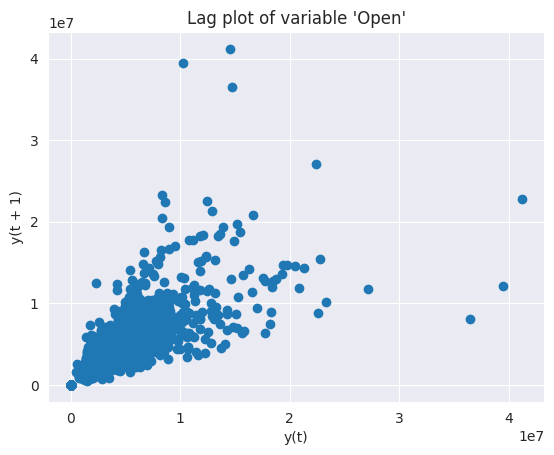

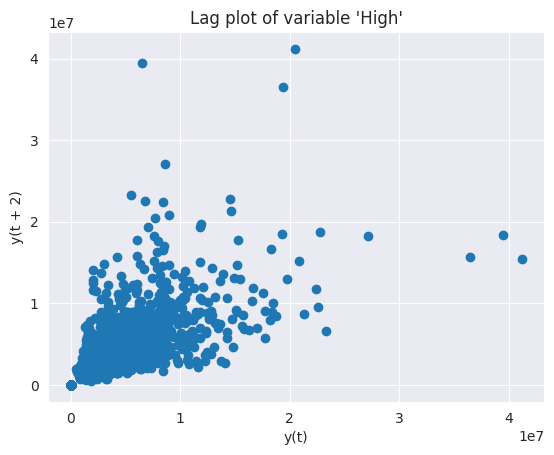

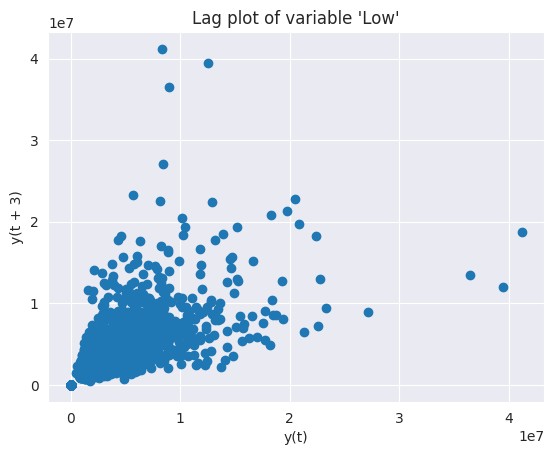

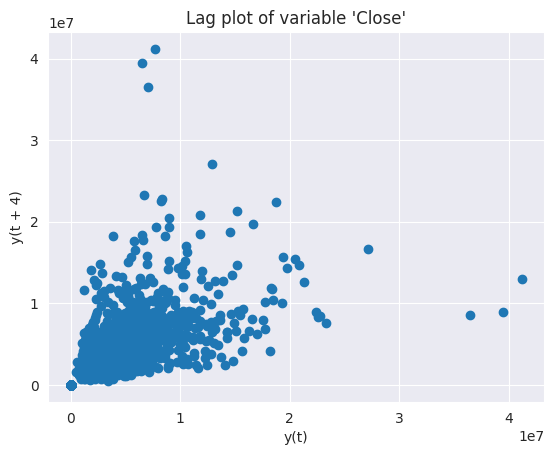

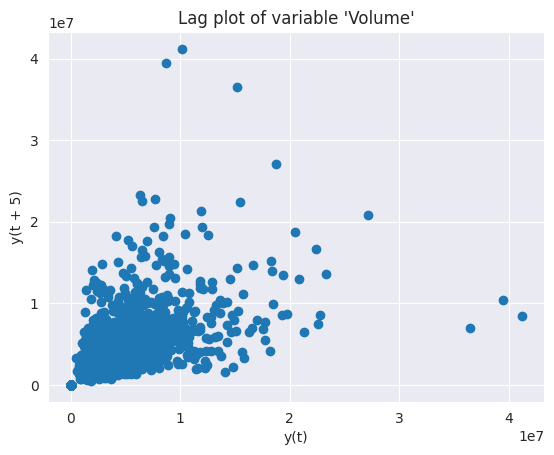

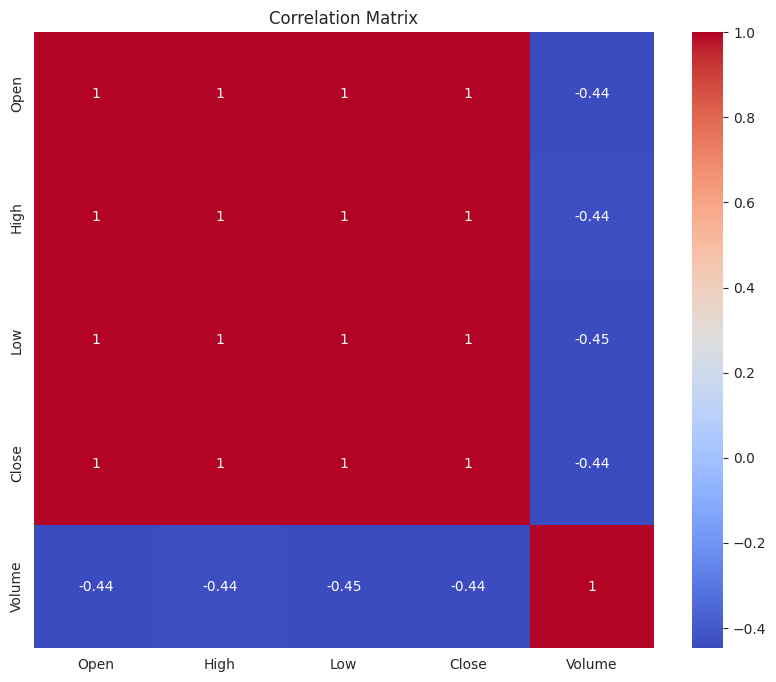

<Figure size 640x480 with 0 Axes>

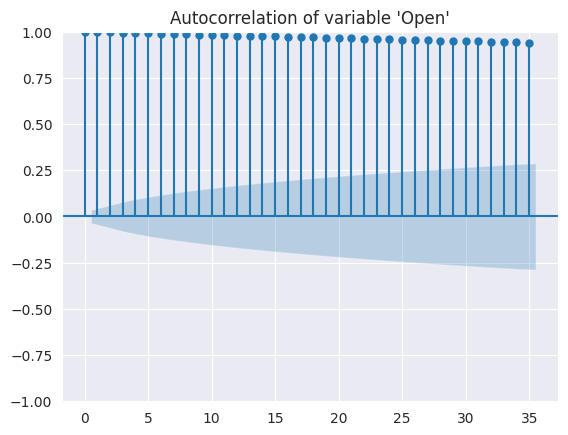

<Figure size 640x480 with 0 Axes>

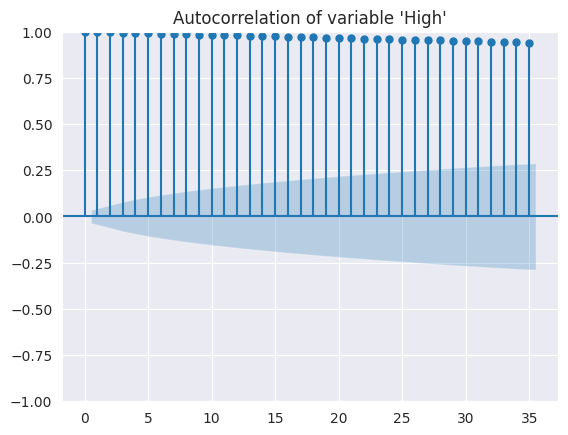

<Figure size 640x480 with 0 Axes>

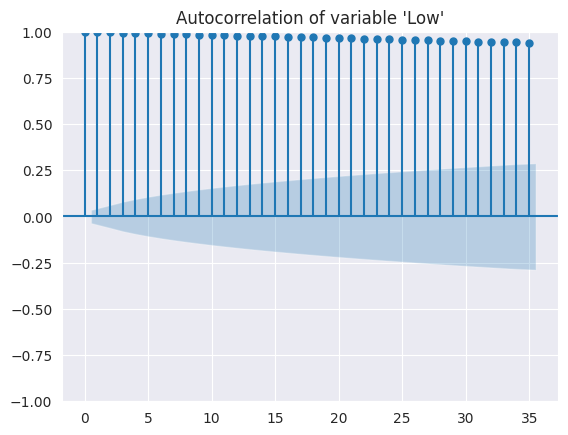

<Figure size 640x480 with 0 Axes>

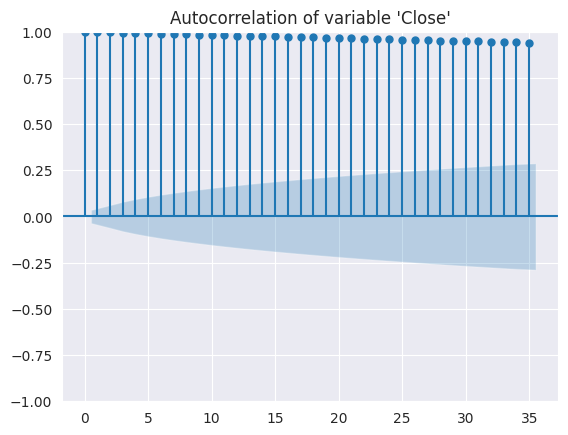

<Figure size 640x480 with 0 Axes>

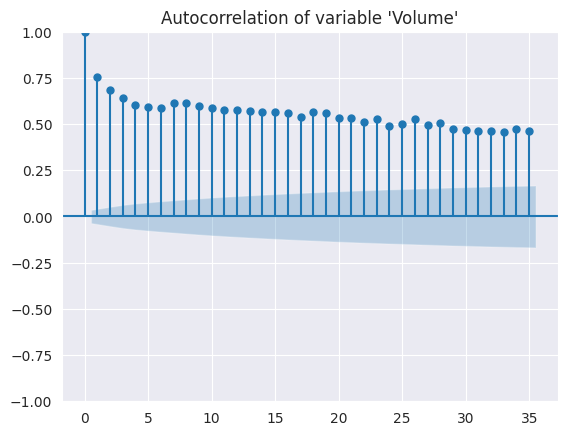

In [ ]:
# lagplot
for i in range(5):
    plt.figure()
    pd.plotting.lag_plot(data, lag=i+1)
    plt.title("Lag plot of variable '" + data.columns[i]  + "'")
    plt.savefig("Lag_plot_" + str(i) + ".png")
 
# extracting only the temperature values
values = pd.DataFrame(data.values)
print(values)

# Create correlation matrix
correlation_matrix = values.corr()

# Print the correlation matrix
print(correlation_matrix)

# Optionally, plot the correlation matrix for better visualization
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=data.columns, yticklabels=data.columns)
plt.title("Correlation Matrix")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

for i in range(5):
    plt.figure()
    plot_acf(data.iloc[:, i])
    plt.title("Autocorrelation of variable '" + data.columns[i]  + "'")
    plt.savefig("auc_" + str(i) + ".png")



$\mathbb{Autoregressive \quad part}$

Try only for Open at the moment

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
cases=["Open", "Close", "Low", "High", "Volume"]
for cs in cases:
  series=data[cs] # change with close, Min, Max, Volume
  T = 10 # we should find a T that creates decets results. 
  X = []
  Y = []


  for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

  X = np.array(X).reshape(-1, T)
  Y = np.array(Y)
  N = len(X)
  print("X.shape", X.shape, "Y.shape", Y.shape)


  # Try autoregressive model
  i = Input(shape=(T,))
  x = Dense(1)(i)
  model = Model(i, x)
  model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1)
  )

  # train 
  r = model.fit(
      X[:-N//2], Y[:-N//2],
      epochs=80,
      validation_data=(X[-N//2:], Y[-N//2:]),
  )

  # Plot loss per iteration
  plt.plot(r.history["loss"], label="Training Loss")
  plt.plot(r.history["val_loss"], label="Validation loss")
  plt.legend()
  plt.savefig("Loss_per_iteration_"+cs+".png")

  # Forecast future values
  validation_target = Y[-int(N*0.2):] # use as validation only the last 20% of the data
  validation_predictions = []

  # Last train input
  last_x = X[-int(N*0.2)]

  while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0, 0] # 1x1 array
  
    # Update predictions list
    validation_predictions.append(p)

    # Make the new input
    last_x = np.roll(last_x, -1) # shift everything one spot to the left, we replace it with the latest forecasted prediction. Multi-step predictions.
    last_x[-1] = p
  
  plt.plot(validation_target, label="forecast_target")
  plt.plot(validation_predictions, label="forecast_prediction")
  plt.legend()
  plt.savefig("forecast_target_vs_prediction_"+cs+".png")

  # Compare rmse of the model and the mean of the residuals: if they are similar, we can say that the model is good
  print("RMSE of the model: ", np.sqrt(np.mean((validation_target - validation_predictions)**2)))
  print("mean of residuals: ",np.mean(results[cs].resid))

SyntaxError: invalid syntax (1161730160.py, line 67)

NameError: name 'result_Open' is not defined